# Unlocking Church Growth: Data Insights from the National Congregations Study
# Worship Service Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to the Worship Service of the congregation and how they may impact an attendance change. The features included are:<br>
 - Services: The number of services per week
 - Lenght: length of service in minutes
 - Sermon: was a sermon involved in the worship service?
 - Sermon Time: length of the sermon in minutes
 - Podium: did the speaker come down off the altar, podium, chancel, or stage during hte sermon?
 - Unique Speakers: how many unique speakers were there?
 - Greetings: Was time allocated for greetings, handshaking, etc. during the service?
 - Kids: was a part of the service specifically for children?
 - Teens: were any speaking, singing, or performing parts specifically for teens in the service?
 - Robe: did the clergy leader wear a robe?
 - Applause: was there applause during any point of the service?
 - Laughing: was laughing invoked during the service?
 - Bulletin: was a program, bulletin, or other written order of service distributed?
 - Streamed: was the service broadcast or streamed live?
 - Smartphone: were people offered the opportunity to use their smartphones to participate in some way?
 - Congregational Reading: did hte congregation speak, read, or recite something together at any point?
 - Offering: was a monetary offering collected during the service?
 - Social Time: how long did people mingle informally before and after the service in minutes?

## Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling
import itertools


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'NUMSERV1', 'LENGTH', 'SERMON', 'SERMTIME', 'SPKRDWN', 'NUMSPOKE', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING', 'SOCLTIME', 'change_category']
df_worship = data[selected_columns].copy()

In [7]:
# Drop DENOM
df_worship.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_worship.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_worship[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
df_worship_encoded = pd.concat([df_worship, encoded_df], axis=1)
df_worship_encoded = df_worship_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [8]:
# Basic exploration
df_worship.info()
df_worship.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NUMSERV1         5322 non-null   float64 
 1   LENGTH           5321 non-null   float64 
 2   SERMON           5326 non-null   object  
 3   SERMTIME         5289 non-null   float64 
 4   SPKRDWN          2777 non-null   object  
 5   NUMSPOKE         1215 non-null   float64 
 6   GREET            5326 non-null   object  
 7   KIDTIME          1232 non-null   object  
 8   TEENPART         1232 non-null   object  
 9   ROBE             4095 non-null   object  
 10  APPLAUSE         5320 non-null   float64 
 11  LAUGH            1228 non-null   object  
 12  PROGRAM          5330 non-null   object  
 13  OVERHEAD         5326 non-null   object  
 14  STREAMED         1254 non-null   object  
 15  SMTPHONE         1255 non-null   object  
 16  CONGREAD         2737 non-null   object  


,NUMSERV1,LENGTH,SERMTIME,NUMSPOKE,APPLAUSE,SOCLTIME
count,5322.000000,5321.000000,5289.000000,1215.000000,5320.000000,4054.000000
mean,5.616967,81.415899,25.555493,3.688889,1.384211,32.827578
std,28.010125,38.381398,20.816414,5.416309,0.486454,26.042180
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,60.000000,15.000000,2.000000,1.000000,15.000000
50%,3.000000,70.000000,20.000000,3.000000,1.000000,30.000000
75%,7.000000,90.000000,35.000000,4.000000,2.000000,40.000000
max,2000.000000,1440.000000,600.000000,125.000000,2.000000,600.000000


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

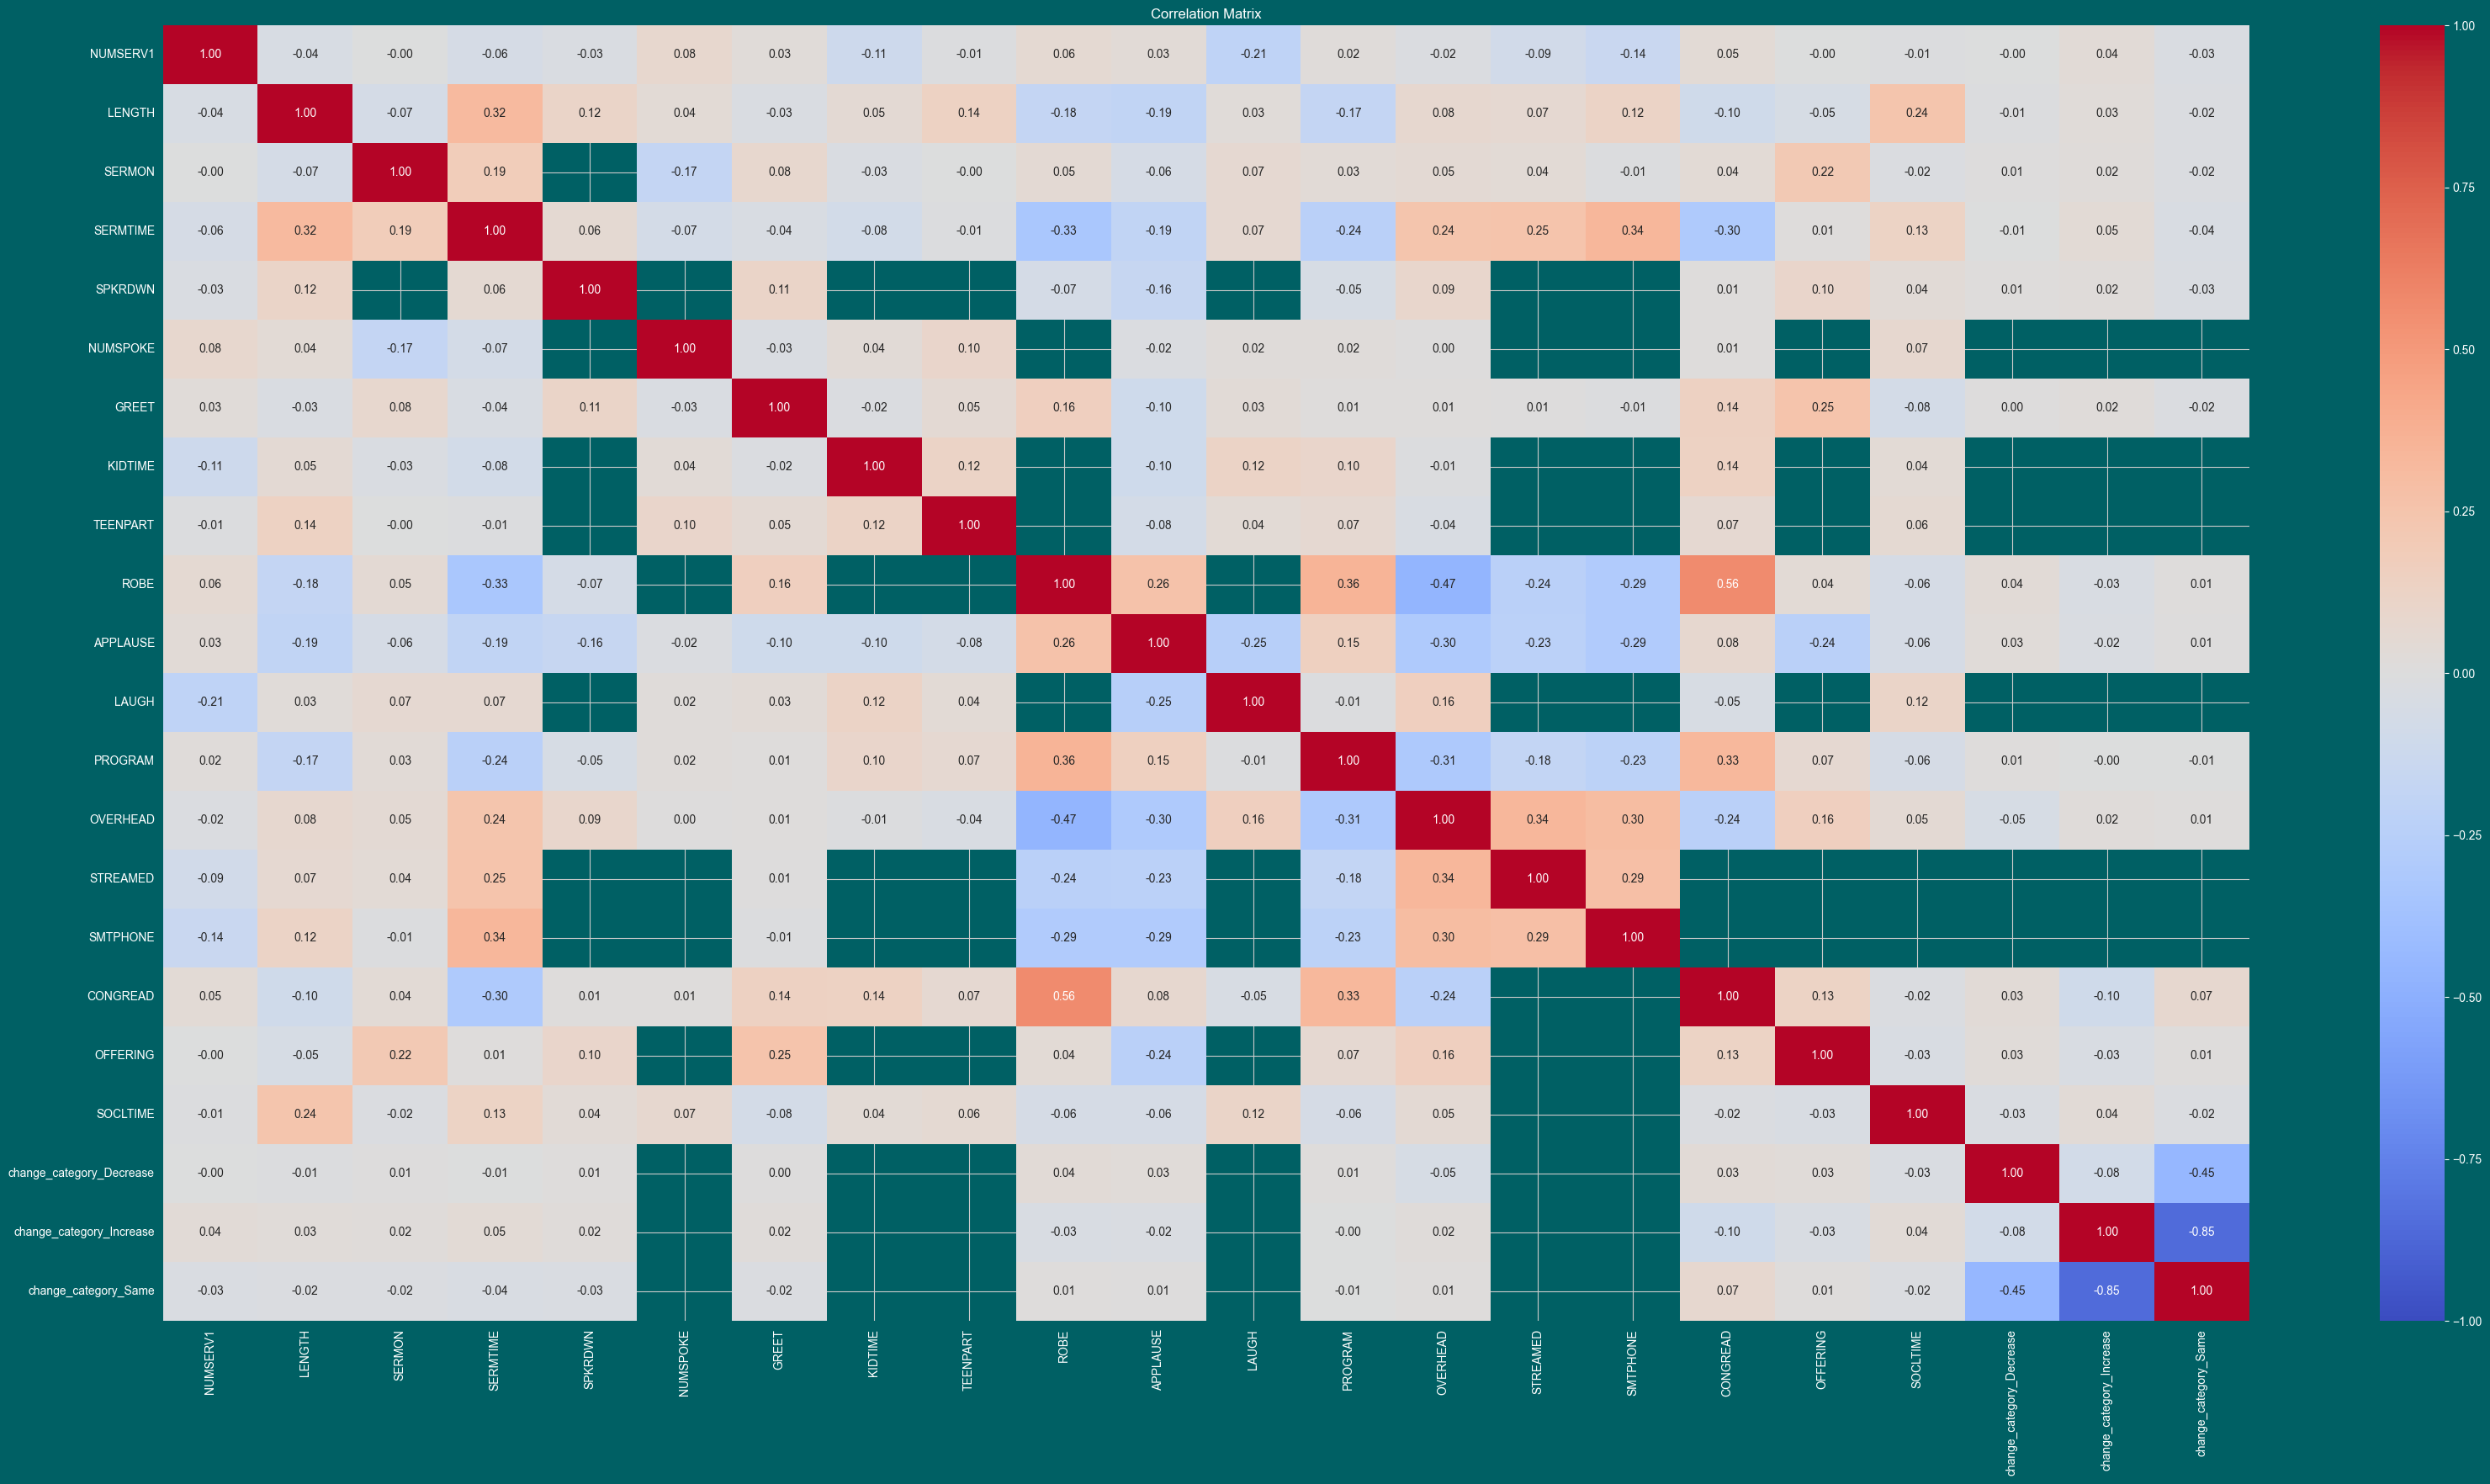

In [9]:
# Perform correlation analysis
correlation_matrix = df_worship_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

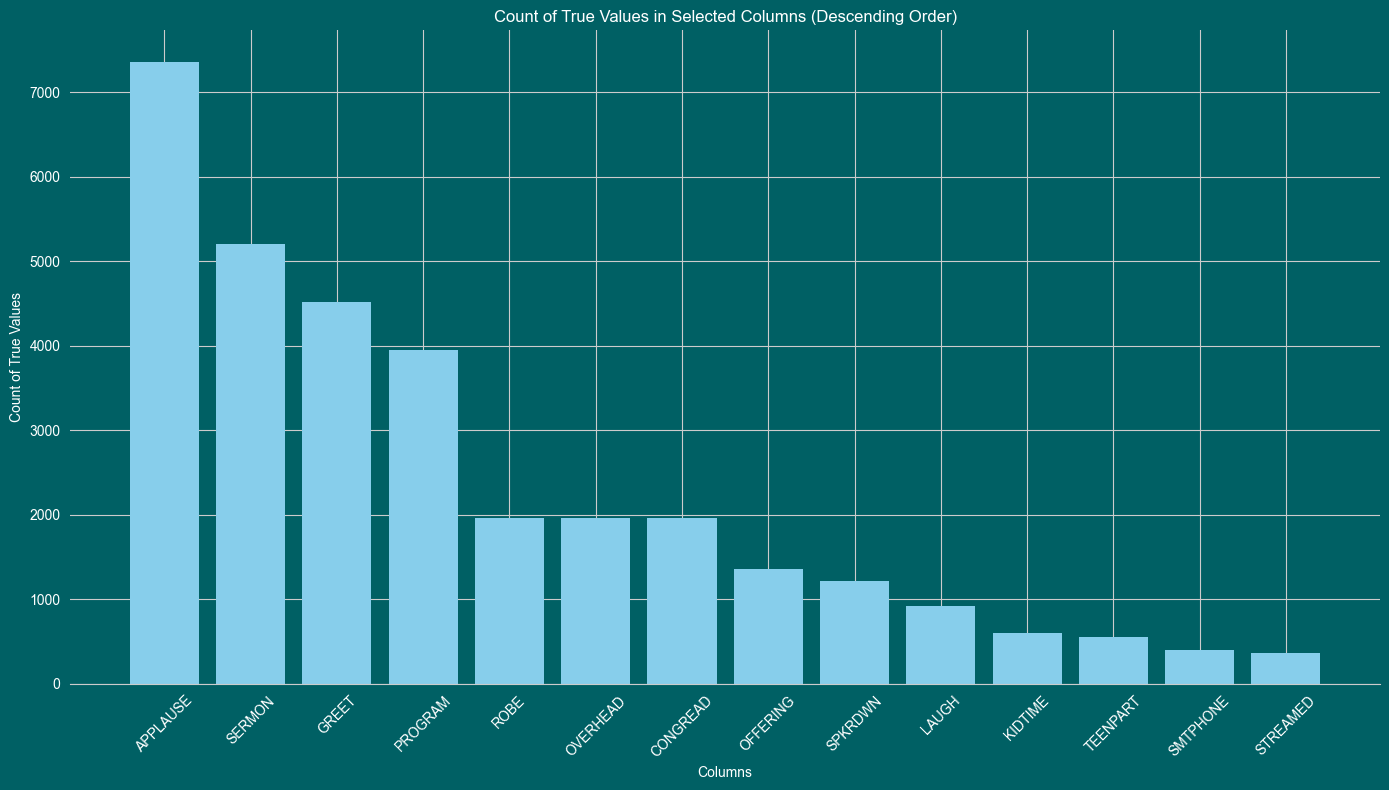

In [10]:
# Specify columns of interest
columns_of_interest = ['SERMON', 'SPKRDWN', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING']

# Count True values for each column
counts = {col: df_worship_encoded[col].sum() for col in columns_of_interest}

# Sort counts in descending order
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Plot counts for each column as multiple bars in one graph
plt.figure(figsize=(14, 8))

# Create the bar plot with sorted counts
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count of True Values')
plt.title('Count of True Values in Selected Columns (Descending Order)')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Count the number of True and False values in the 'APPLAUSE' column
applause_counts = df_worship_encoded['APPLAUSE'].value_counts()

# Print the counts
print("Counts of boolean values in 'APPLAUSE':")
print(applause_counts)

Counts of boolean values in 'APPLAUSE':
APPLAUSE
1.0    3276
2.0    2044
Name: count, dtype: int64


## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [ ]:
# Inferential Analysis

# Select specific features and drop rows with missing target data
df_facilities_inferential = data[['BLDGTYPE', 'VIEWBLDG', 'REMODEL', 'HOMESCHL', 'HAVESCHL', 'USEBLDG', 'PERMPURP', 'change_category']]

# Drop rows with missing target data
df_facilities_inferential = df_facilities_inferential.dropna(subset=['change_category'])

# Convert facility type columns to categorical
facilities_types = ['VIEWBLDG', 'REMODEL', 'HOMESCHL', 'HAVESCHL', 'USEBLDG']
for col in facilities_types:
    df_facilities_inferential[col] = df_facilities_inferential[col].astype('category')

# Function to perform Chi-Square test
def perform_chi2_test(df, feature):
    contingency_table = pd.crosstab(df[feature], df['change_category'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_val

# Perform Chi-Square test for each feature
chi2_results = {feature: perform_chi2_test(df_facilities_inferential, feature) for feature in facilities_types}

# Display Chi-Square results
for feature, (chi2_stat, p_val) in chi2_results.items():
    print(f"Chi-Square test for {feature}: Chi2-statistic = {chi2_stat:.4f}, p-value = {p_val:.4e}")

In [ ]:
# Function to plot relationship
def plot_relationship(df, feature):
    contingency_table = pd.crosstab(df[feature], df['change_category'])
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Relationship between {feature} and change_category')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Change Category')
    plt.show()

# Plot relationships
for feature in facilities_types:
    plot_relationship(df_facilities_inferential, feature)

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

In [ ]:
# Determine NaN value counts in each column
nan_counts = df_facilities.isnull().sum()
print("NaN value counts in each column:")
print(nan_counts)

In [ ]:
# Logistic Regression

# Select specific columns and drop NaN values
df_facilities_logit = df_facilities[['REMODEL', 'HOMESCHL', 'HAVESCHL', 'change_category']].dropna()

# One-Hot Encoding for the target variable
df_facilities_logit['change_category'] = df_facilities_logit['change_category'].astype('category')
encoder = OneHotEncoder(sparse_output=False)
encoded_target = encoder.fit_transform(df_facilities_logit[['change_category']])
encoded_target_df = pd.DataFrame(encoded_target, columns=encoder.get_feature_names_out(['change_category']))

# Merge encoded target with the main dataframe and drop the original target column
df_facilities_logit = pd.concat([df_facilities_logit.reset_index(drop=True), encoded_target_df], axis=1)
df_facilities_logit.drop(['change_category'], axis=1, inplace=True)

# Encode the target variable for logistic regression
# Assuming 'change_category_Increase' is the column for the positive class
target = df_facilities_logit['change_category_Increase']
df_facilities_logit.drop(['change_category_Increase', 'change_category_Decrease', 'change_category_Same'], axis=1, inplace=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_facilities_logit, target, test_size=0.3, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.coef_[0], index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

In [ ]:
# Random Forest

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

In [ ]:
# Define the feature combinations to test
input_combinations = pd.DataFrame({
    'REMODEL': [1, 0, 1, 0, 1, 0, 0, 0],  # Test various combinations of 'yes' (1) and 'no' (0)
    'HOMESCHL': [1, 1, 0, 0, 1, 1, 0, 0],
    'HAVESCHL': [1, 1, 1, 1, 0, 0, 0, 0],
    # Add other features if needed; here we assume they are all zero
})

# Ensure all columns are present in the input combinations
for col in X_train.columns:
    if col not in input_combinations.columns:
        input_combinations[col] = 0

# Predict probabilities using the Random Forest model
predicted_probs = model.predict_proba(input_combinations)

# Convert predictions to a DataFrame for visualization
# The `model.classes_` should be ['decrease', 'increase', 'same'] or in a similar order
predicted_df = pd.DataFrame(predicted_probs, columns=model.classes_)
predicted_df['Combination'] = ['Remodel=Yes, Homeschl=Yes, Haveschl=Yes', 
                               'Remodel=No, Homeschl=Yes, Haveschl=Yes',
                               'Remodel=Yes, Homeschl=No, Haveschl=Yes',
                               'Remodel=No, Homeschl=No, Haveschl=Yes',
                               'Remodel=Yes, Homeschl=Yes, Haveschl=No',
                               'Remodel=No, Homeschl=Yes, Haveschl=No',
                               'Remodel=Yes, Homeschl=No, Haveschl=No',
                               'Remodel=No, Homeschl=No, Haveschl=No']

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(predicted_df, id_vars='Combination', var_name='Change Category', value_name='Probability')

# Plotting the probabilities
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='Combination', y='Probability', hue='Change Category', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Probability')
plt.title('Predicted Probabilities for Change Category for Various Feature Combinations')
plt.tight_layout()
plt.legend(title='Change Category')
plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.